**ОБРАБОТКА ДАННЫХ**

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('train.csv')
data.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


Из данных видно, что только в столбце Arrival Delay in Minutes есть 310 пустых строк

In [4]:
data.isnull().sum()

,0
Unnamed: 0,0
id,0
Gender,0
Customer Type,0
Age,0
Type of Travel,0
Class,0
Flight Distance,0
Inflight wifi service,0
Departure/Arrival time convenient,0


In [5]:
#доля пустых значений
missing_count = data['Arrival Delay in Minutes'].isnull().sum()
missing_pct = 100 * data['Arrival Delay in Minutes'].isnull().sum() / len(data['Arrival Delay in Minutes'])

print(f"Пропусков: {missing_count} ({missing_pct:.2f}%)")

Пропусков: 310 (0.30%)


Так как пустых значений 0.3%, то эти строки можно спокойно удалить, чтобы это не повлияло на качество модели.

In [6]:
data = data.dropna()

Избавляемся от столбца, который используется для обозначения ID-колонки и не несет в себе какую-то полезную информацию

In [7]:
data = data.drop(['Unnamed: 0', 'id'], axis=1)

Дубликатов в данных нет

In [8]:
data.duplicated().sum()

np.int64(0)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103594 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103594 non-null  object 
 1   Customer Type                      103594 non-null  object 
 2   Age                                103594 non-null  int64  
 3   Type of Travel                     103594 non-null  object 
 4   Class                              103594 non-null  object 
 5   Flight Distance                    103594 non-null  int64  
 6   Inflight wifi service              103594 non-null  int64  
 7   Departure/Arrival time convenient  103594 non-null  int64  
 8   Ease of Online booking             103594 non-null  int64  
 9   Gate location                      103594 non-null  int64  
 10  Food and drink                     103594 non-null  int64  
 11  Online boarding                    103594 no

Построим boxplot графики, чтобы наглядно увидеть в каких столбцах у нас есть выбросы

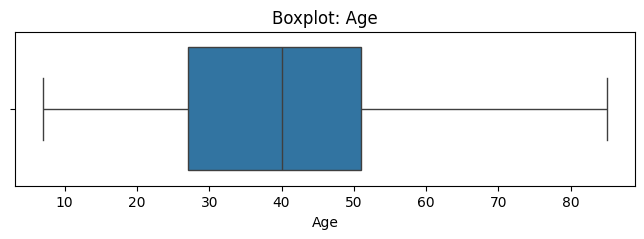

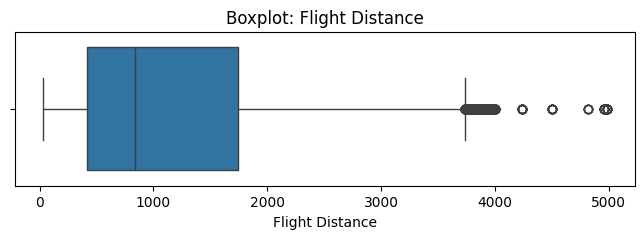

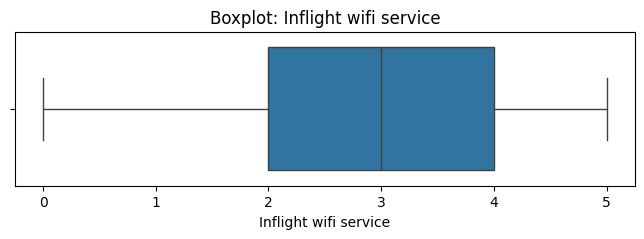

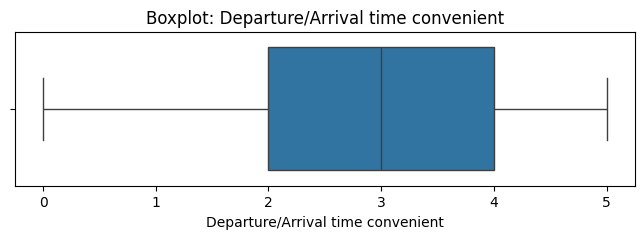

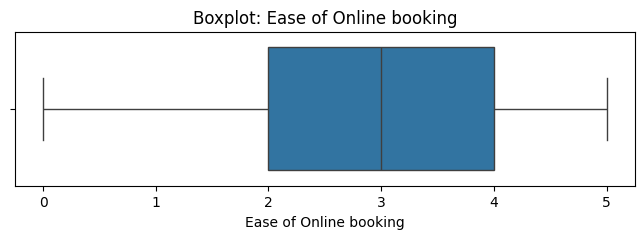

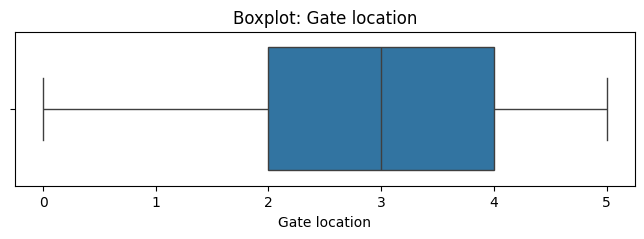

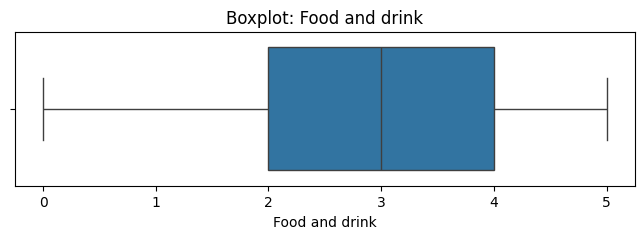

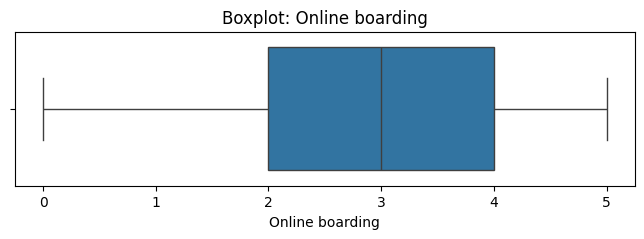

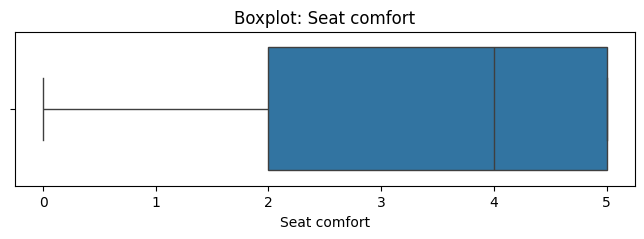

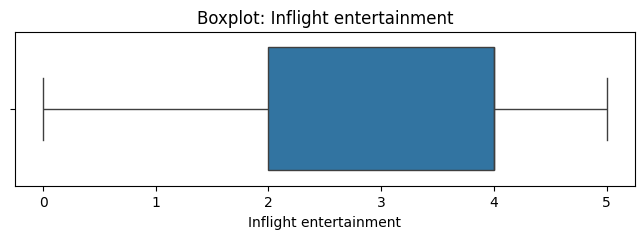

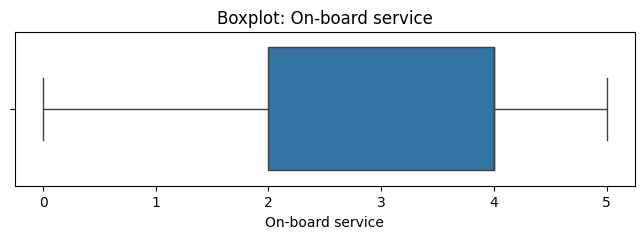

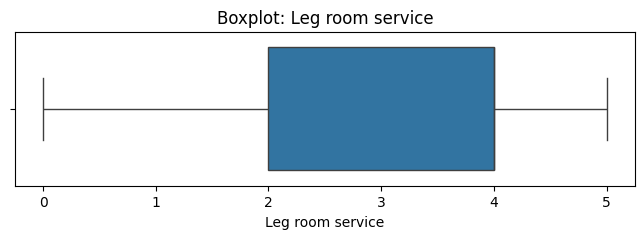

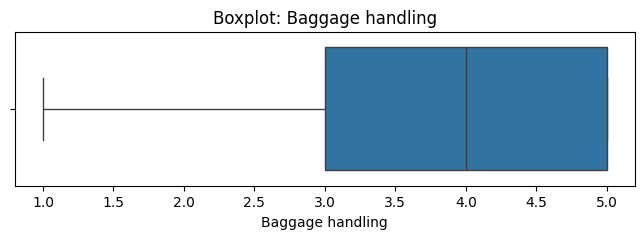

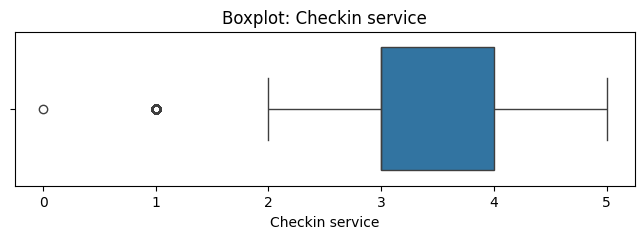

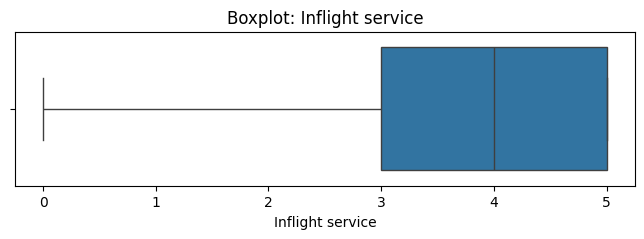

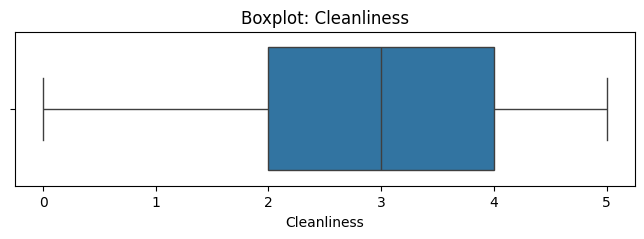

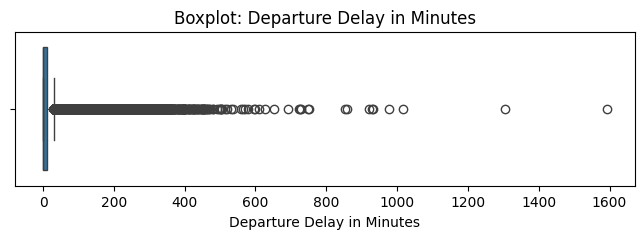

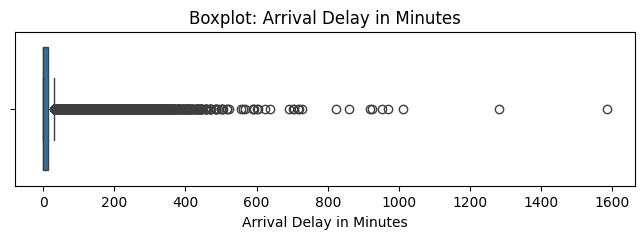

In [10]:
numeric_cols = data.select_dtypes(include='number').columns

for col in numeric_cols:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot: {col}')
    plt.show()

Заметны выбросы в столбцах Flight Distance, Checkin service, Departure Delay in Minutes, Arrival Delay in Minutes. Нужно детальнее рассмотреть данные столбцы, чтобы понять насколько реальны эти данные

In [11]:
data[['Flight Distance', 'Checkin service', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']].describe()

,Flight Distance,Checkin service,Departure Delay in Minutes,Arrival Delay in Minutes
count,103594.000000,103594.000000,103594.000000,103594.000000
mean,1189.325202,3.304323,14.747939,15.178678
std,997.297235,1.265396,38.116737,38.698682
min,31.000000,0.000000,0.000000,0.000000
25%,414.000000,3.000000,0.000000,0.000000
50%,842.000000,3.000000,0.000000,0.000000
75%,1743.000000,4.000000,12.000000,13.000000
max,4983.000000,5.000000,1592.000000,1584.000000


Перелет с расстоянием 4983 км реален, если в столбце обслуживания 0 значит оно не было оценено, задержка вылета и прибытия может быть больше суток, поэтому эти данные тоже не считаются выбросами

Так как есть столбцы, где 0 обозначает, что рейтинг не определен, то нужно их тоже обработать, так как иначе будет не правильная интерпретация данных

In [12]:
cols_to_replace = [
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Ease of Online booking',
    'Gate location',
    'Food and drink',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'Cleanliness'
]

# Заменяем 0 на NaN во всех перечисленных колонках
data[cols_to_replace] = data[cols_to_replace].replace(0, np.nan)

# Проверим, сколько теперь NaN в этих колонках
print(data[cols_to_replace].isnull().sum())

Inflight wifi service                3096
Departure/Arrival time convenient    5290
Ease of Online booking               4473
Gate location                           1
Food and drink                        105
Online boarding                      2420
Seat comfort                            1
Inflight entertainment                 14
On-board service                        3
Leg room service                      470
Baggage handling                        0
Checkin service                         1
Inflight service                        3
Cleanliness                            12
dtype: int64


Используем метод KNN, чтобы заполнить данные, где 0 обозначалось в случае, если пассажир не оценил сервис

In [13]:
# Масштабируем
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[cols_to_replace])

# Запускаем KNN Imputer
imputer = KNNImputer(n_neighbors=5)
data_imputed_scaled = imputer.fit_transform(data_scaled)

data_imputed = scaler.inverse_transform(data_imputed_scaled)

data[cols_to_replace] = data_imputed

# Проверяем — есть ли ещё пропуски
print(data[cols_to_replace].isnull().sum())

Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
dtype: int64


In [14]:
data_new = data.copy() #сохраним для Catboost так
data_new['satisfaction'] = data_new['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)

Обработаем категориальные признаки

In [15]:
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
print("Категориальные признаки:")
print(categorical_cols)

Категориальные признаки:
['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']


In [16]:
data = pd.get_dummies(data, columns=['Class', 'Type of Travel', 'Gender', 'Customer Type', 'satisfaction'], drop_first=True).astype(int)

Построим корреляционную таблицу, чтобы увидеть, от каких фичей нам нужно избавиться

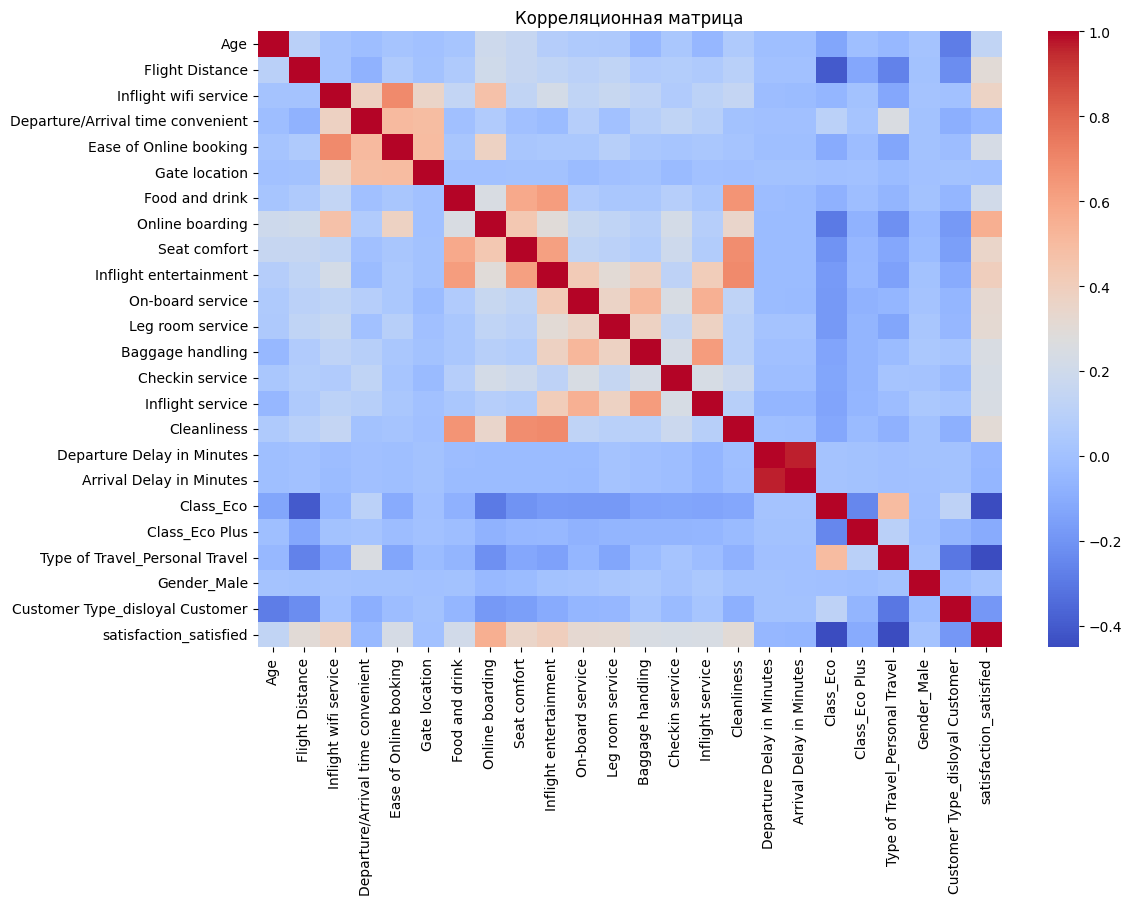

In [17]:
corr_mat = data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_mat, annot=False, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

Признаки, которые сильно скоррелированы нужно будет объединить или какой-то из них убрать, чтобы снизить риск переобучения и повысить стабильность модели.

In [18]:
# Матрица корреляции
corr_matrix = data.corr().abs()  # abs() берём модуль, чтобы найти и сильную отрицательную, и положительную связь

np.fill_diagonal(corr_matrix.values, np.nan)

high_corr_pairs = (
    corr_matrix.stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2', 0: 'Correlation'})
)

high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.7]

high_corr_pairs['Pairs'] = high_corr_pairs.apply(lambda row: tuple(sorted([row['Feature1'], row['Feature2']])), axis=1)
high_corr_pairs = high_corr_pairs.drop_duplicates(subset=['Pairs'])

print("Пары признаков с корреляцией > 0.7:\n")
print(high_corr_pairs[['Feature1', 'Feature2', 'Correlation']])

Пары признаков с корреляцией > 0.7:

                       Feature1                  Feature2  Correlation
384  Departure Delay in Minutes  Arrival Delay in Minutes     0.965481


Так как Departure Delay in Minutes и Arrival Delay in Minutes вносят одинаковый вклад в целевую переменную, но при этом сильно коррелируют между собой, то нужно избавиться от одной из них.

In [19]:
data = data.drop('Arrival Delay in Minutes', axis=1)
data_new = data_new.drop('Arrival Delay in Minutes', axis=1)

Можно считать, что классы сбалансированы

In [23]:
data.groupby('satisfaction_satisfied', as_index=False).size()

,satisfaction_satisfied,size
0,0,58697
1,1,44897


**Обучение**

Так как у нас происходит классификация довольних и не довольных пассажиров, то предполагаем, что важнее выявлять недовольных клиентов, чтобы предотвратить отток или жалобы. То есть ориентироваться будем на метрику Recall для класса 0, но за остальными метриками мы тоже будем следить

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import seaborn as sns
import catboost


X = data.drop('satisfaction_satisfied', axis=1)
y = data['satisfaction_satisfied']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)

(82875, 22) (20719, 22)


Logistic Regression

Лучшие параметры: {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Лучший score: 0.8832579185520363
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     11740
           1       0.87      0.85      0.86      8979

    accuracy                           0.88     20719
   macro avg       0.88      0.88      0.88     20719
weighted avg       0.88      0.88      0.88     20719



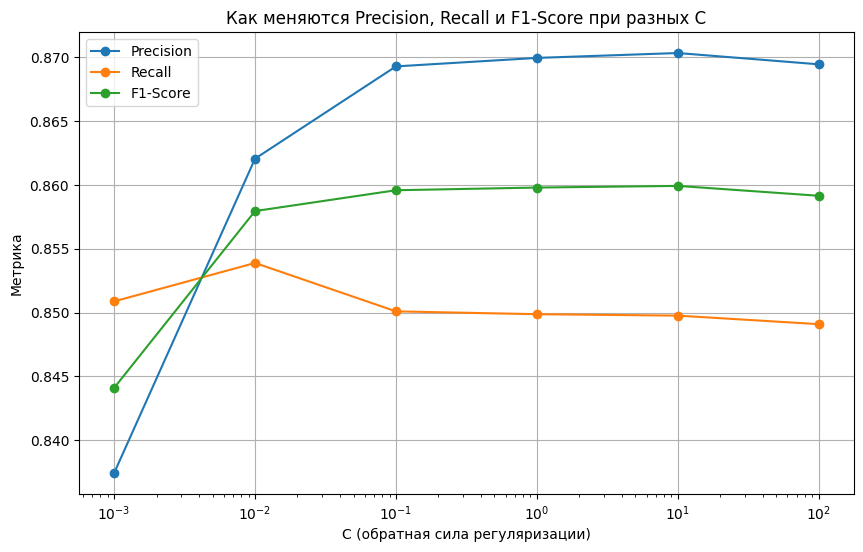

CPU times: user 27.3 s, sys: 138 ms, total: 27.4 s
Wall time: 27.5 s


In [21]:
%%time
pipeline = Pipeline([
    ('scaler', StandardScaler()), #нормализуем признаки
    ('logreg', LogisticRegression(max_iter=500))
])

param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['liblinear']
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший score:", grid.best_score_)

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

C_values = [0.001, 0.01, 0.1, 1, 10, 100] #изменяем параметр, который штрафует модель и чем меньше данный параметр тем больше он будет штрафовать, чтобы подобрать лучший
precisions = []
recalls = []
f1s = []
for C in C_values:
    model = LogisticRegression(C=C, penalty='l2', solver='liblinear', max_iter=500)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(C_values, precisions, label='Precision', marker='o')
plt.plot(C_values, recalls, label='Recall', marker='o')
plt.plot(C_values, f1s, label='F1-Score', marker='o')

plt.xscale('log')
plt.xlabel('C (обратная сила регуляризации)')
plt.ylabel('Метрика')
plt.title('Как меняются Precision, Recall и F1-Score при разных C')
plt.legend()
plt.grid(True)
plt.show()

В среднем модель правильно разделяет довольных и недовольных с точностью ~88%, хорошо ловит недовольных (90% Recall), при этом даёт мало ложных срабатываний — Precision ~89%. Оптимальный вариант параметра C является 1, так как в этот момент метрики выравниваются

In [22]:
train_pred = grid.predict(X_train)
test_pred = grid.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, train_pred))
print("Test accuracy:", accuracy_score(y_test, test_pred))

Train accuracy: 0.8833544494720965
Test accuracy: 0.8792895410010135


Модель показывает стабильное качество: на новых данных она сохраняет точность предсказаний на уровне ~87%. Это значит, что она способна надёжно предсказывать поведение клиентов, а не просто подгоняться под прошлое

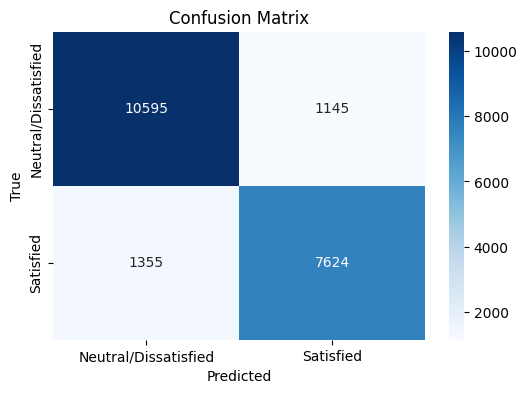

In [23]:
# Матрица
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Neutral/Dissatisfied', 'Satisfied'],
    yticklabels=['Neutral/Dissatisfied', 'Satisfied']
)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Модель правильно определяет ~90% Neutral/Dissatisfied клиентов — значит можно эффективно направлять удерживающие предложения, чтобы пытаться как-то сохранить не довольных пассажиров

Random Forest

=== Базовый Random Forest ===
Accuracy: 0.9464742506877745
Classification Report:               precision    recall  f1-score   support

           0       0.93      0.98      0.95     11740
           1       0.97      0.91      0.94      8979

    accuracy                           0.95     20719
   macro avg       0.95      0.94      0.95     20719
weighted avg       0.95      0.95      0.95     20719



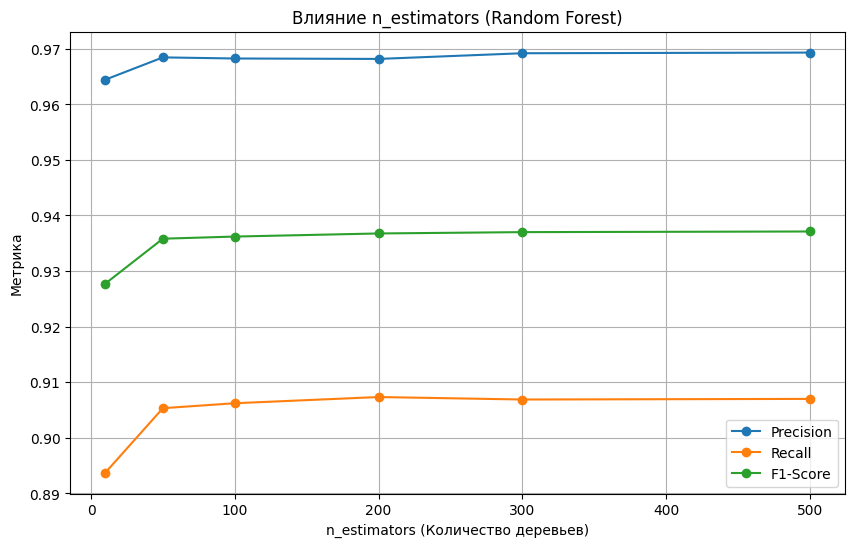

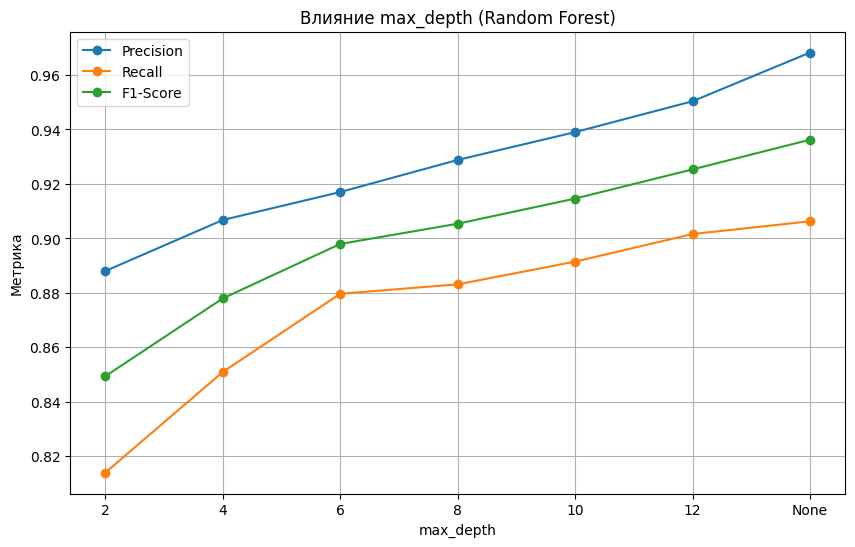

CPU times: user 3min 24s, sys: 700 ms, total: 3min 25s
Wall time: 3min 25s


In [24]:
%%time
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_train_rf = rf.predict(X_train)

print("=== Базовый Random Forest ===")
print("Accuracy test:", accuracy_score(y_test, y_pred_rf))
print("Accuracy train:", accuracy_score(y_train, y_train_rf))
print("Classification Report:", classification_report(y_test, y_pred_rf))


n_estimators_range = [10, 50, 100, 200, 300, 500] #изменяем кол-во деревьев в случайном лесу
precisions = []
recalls = []
f1s = []

for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, precisions, label='Precision', marker='o')
plt.plot(n_estimators_range, recalls, label='Recall', marker='o')
plt.plot(n_estimators_range, f1s, label='F1-Score', marker='o')
plt.xlabel('n_estimators (Количество деревьев)')
plt.ylabel('Метрика')
plt.title('Влияние n_estimators (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

depth_range = [2, 4, 6, 8, 10, 12, None] #изменяем глубину дерева
precisions = []
recalls = []
f1s = []

for d in depth_range:
    rf = RandomForestClassifier(n_estimators=100, max_depth=d, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

depth_labels = [str(d) if d is not None else 'None' for d in depth_range]

plt.figure(figsize=(10, 6))
plt.plot(depth_labels, precisions, label='Precision', marker='o')
plt.plot(depth_labels, recalls, label='Recall', marker='o')
plt.plot(depth_labels, f1s, label='F1-Score', marker='o')
plt.xlabel('max_depth')
plt.ylabel('Метрика')
plt.title('Влияние max_depth (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

У базового Random Forest на тренировочной выборке точность 100%, а на тестовой 96%, это означает, что модель переобучилась и подстроилась под данные(

Для Random Forest можно выбирать n_estimators ~100–200. Больше — почти не даёт прироста, но грузит ресурсы. Увеличение глубины деревьев сильно влияет на метрики. При max_depth > 8 прирост снижается — значит, оптимально держать деревья глубокими, но с ограничением, чтобы избежать переобучения

Признаки, которые больше всех повлияли на случайный лес

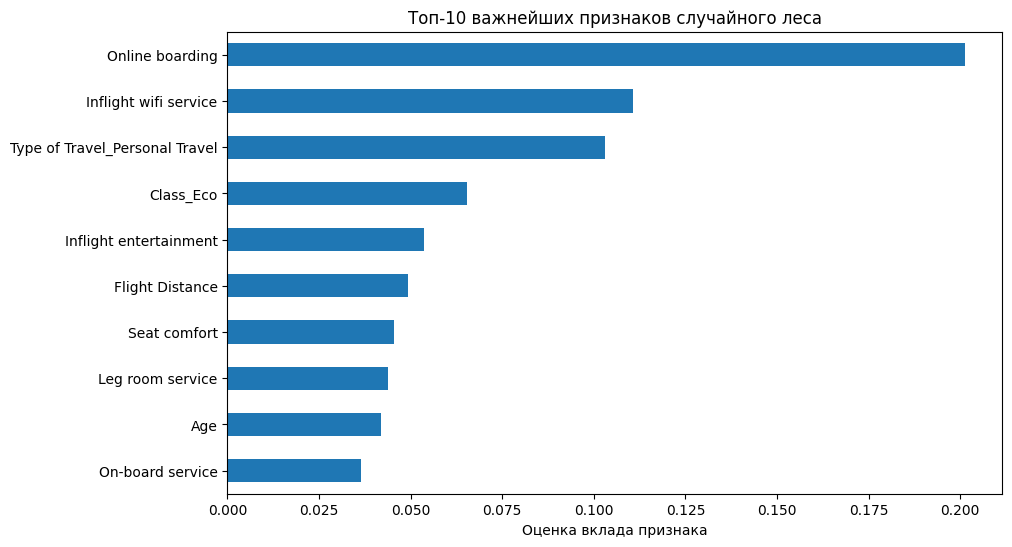

In [25]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=X_test.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importance.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Топ-10 важнейших признаков случайного леса')
plt.xlabel('Оценка вклада признака')
plt.show()

По данным видно, что онлайн регистрация самый значимый признак для модели. А наличие Wi-Fi на борту и причина поездки (личная или деловая) также существенно влияют на удовлетворенность пассажира.

In [26]:
train_pred = grid.predict(X_train)
test_pred = grid.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, train_pred))
print("Test accuracy:", accuracy_score(y_test, test_pred))
print("Classification Report:", classification_report(y_test, test_pred))

Train accuracy: 0.8833544494720965
Test accuracy: 0.8792895410010135
Classification Report:               precision    recall  f1-score   support

           0       0.89      0.90      0.89     11740
           1       0.87      0.85      0.86      8979

    accuracy                           0.88     20719
   macro avg       0.88      0.88      0.88     20719
weighted avg       0.88      0.88      0.88     20719



Модель правильно классифицирует ~95% клиентов.
Она находит почти всех Neutral/Dissatisfied клиентов (Recall = 96%), и с высокой вероятностью правильно определяет довольных (Recall = 94%).
Точность по обоим классам тоже очень высока, что значит — мало ложных срабатываний. Все метрики стали выше, обучение по времени чуть больше.

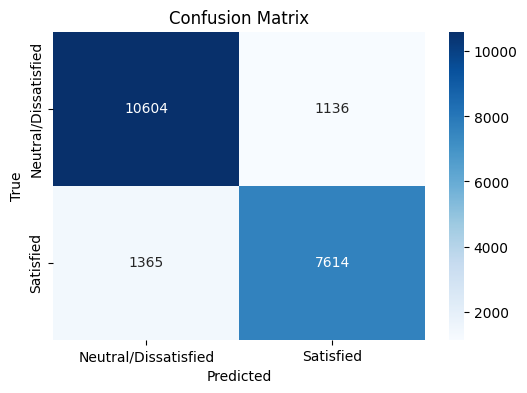

In [27]:
#Матрица
y_pred = grid.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Neutral/Dissatisfied', 'Satisfied'],
    yticklabels=['Neutral/Dissatisfied', 'Satisfied']
)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Модель правильно определяет большинство Neutral/Dissatisfied клиентов (11327), ошибочно относя к довольным всего ~413.
А довольных клиентов ловит с высокой точностью (8402), ошибочно относя 577 довольных к недовольным

XGBoost

In [28]:
%%time
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 6],
    'learning_rate': [0.02, 0.05, 0.1]
}

grid = GridSearchCV(
    XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

# Новый сплит для валидации
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Чистый XGBClassifier
best_xgb = XGBClassifier(
    **grid.best_params_,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Финальный fit
best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)]
)

# Предсказания
y_pred_test = best_xgb.predict(X_test)
y_pred_train = best_xgb.predict(X_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:51:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
[0]	validation_0-logloss:0.61606	validation_1-logloss:0.61587
[1]	validation_0-logloss:0.55958	validation_1-logloss:0.55926
[2]	validation_0-logloss:0.51365	validation_1-logloss:0.51323
[3]	validation_0-logloss:0.47401	validation_1-logloss:0.47347
[4]	validation_0-logloss:0.44004	validation_1-logloss:0.43956
[5]	validation_0-logloss:0.41038	validation_1-logloss:0.40978
[6]	validation_0-logloss:0.38522	validation_1-logloss:0.38463
[7]	validation_0-logloss:0.36294	validation_1-logloss:0.36223


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:51:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-logloss:0.34392	validation_1-logloss:0.34334
[9]	validation_0-logloss:0.32645	validation_1-logloss:0.32580
[10]	validation_0-logloss:0.31174	validation_1-logloss:0.31113
[11]	validation_0-logloss:0.29819	validation_1-logloss:0.29751
[12]	validation_0-logloss:0.28651	validation_1-logloss:0.28578
[13]	validation_0-logloss:0.27543	validation_1-logloss:0.27459
[14]	validation_0-logloss:0.26620	validation_1-logloss:0.26528
[15]	validation_0-logloss:0.25733	validation_1-logloss:0.25644
[16]	validation_0-logloss:0.24974	validation_1-logloss:0.24884
[17]	validation_0-logloss:0.24252	validation_1-logloss:0.24167
[18]	validation_0-logloss:0.23529	validation_1-logloss:0.23443
[19]	validation_0-logloss:0.22903	validation_1-logloss:0.22823
[20]	validation_0-logloss:0.22310	validation_1-logloss:0.22242
[21]	validation_0-logloss:0.21793	validation_1-logloss:0.21736
[22]	validation_0-logloss:0.21344	validation_1-logloss:0.21304
[23]	validation_0-logloss:0.20939	validation_1-logloss:0.

In [29]:
print("Train accuracy:", accuracy_score(y_pred_train, y_train))
print("Test accuracy:", accuracy_score(y_pred_test, y_test))
print("Classification Report:", classification_report(y_pred_test, y_test))

Train accuracy: 0.9587209653092006
Test accuracy: 0.9499975867561176
Classification Report:               precision    recall  f1-score   support

           0       0.98      0.94      0.96     12270
           1       0.91      0.97      0.94      8449

    accuracy                           0.95     20719
   macro avg       0.95      0.95      0.95     20719
weighted avg       0.95      0.95      0.95     20719



Хоршее предсказание.Точно отлавливает недовольных, почти без ложных довольных. Accuracy ~96% для задач классификации с перекосом классов. Модель генерализует стабильно.


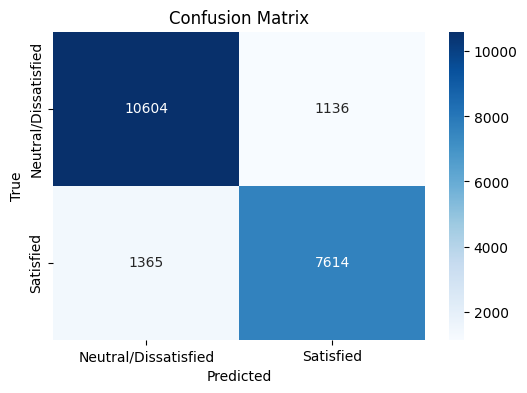

In [30]:
# Матрица
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Neutral/Dissatisfied', 'Satisfied'],
    yticklabels=['Neutral/Dissatisfied', 'Satisfied']
)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

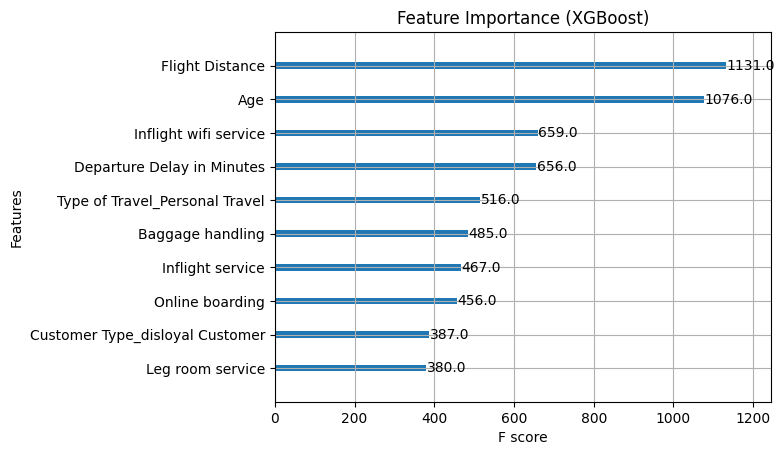

In [31]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score, precision_recall_curve,
    classification_report, accuracy_score
)

from xgboost import plot_importance
plot_importance(best_xgb, max_num_features=10)
plt.title('Feature Importance (XGBoost)')
plt.show()

На графике показано сколько раз признак использовался при разбиение. Это значит, что уровень удовлетворённости Wi-Fi на борту сильнее всего влияет на итоговое предсказание лояльности клиента. Клиенты по-разному оценивают сервис на коротких и дальних рейсах. Возраст влияет на восприятие сервиса.

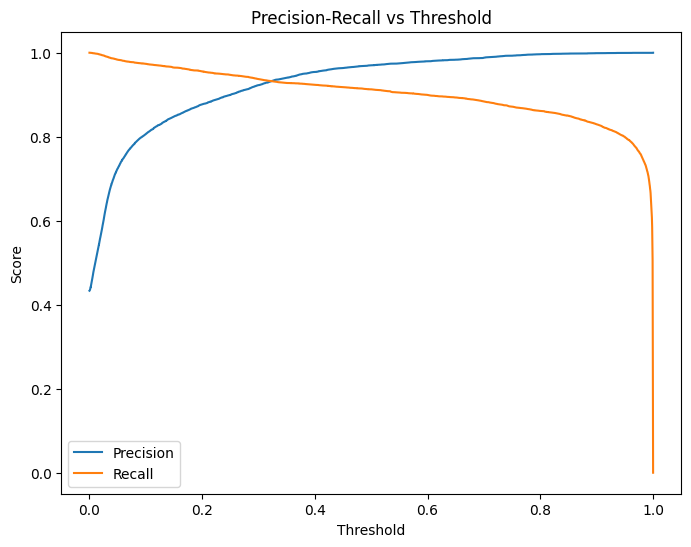

In [32]:
y_proba = best_xgb.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.show()

Точка пересечения линий показывает баланс Precision = Recall. Наша цель поймать недовольных клиентов, поэтому для нас важнее Recall → лучше выбрать порог чуть левее пересечения. Если хочешь минимизировать ложные «недовольные» → смещаешь порог вправо, жертвуя Recall ради Precision.



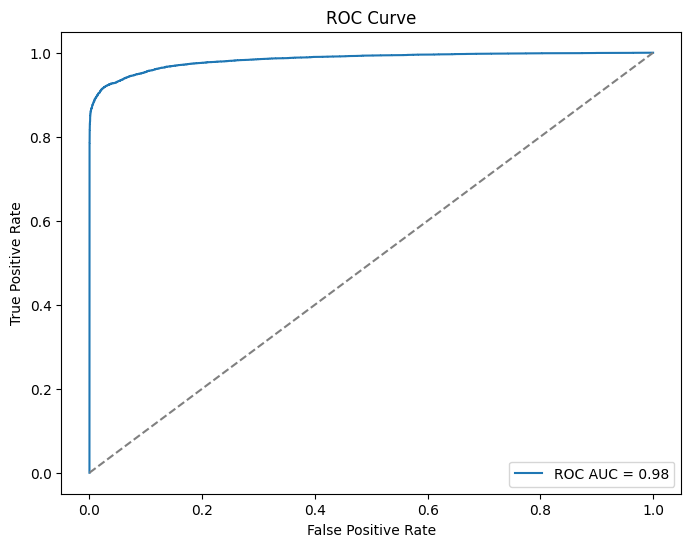

In [33]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

По данному графику можно заметить, что у нас минимальные потери по ложному действию, так как TPR ≈ 1 и FPR ≈ 0

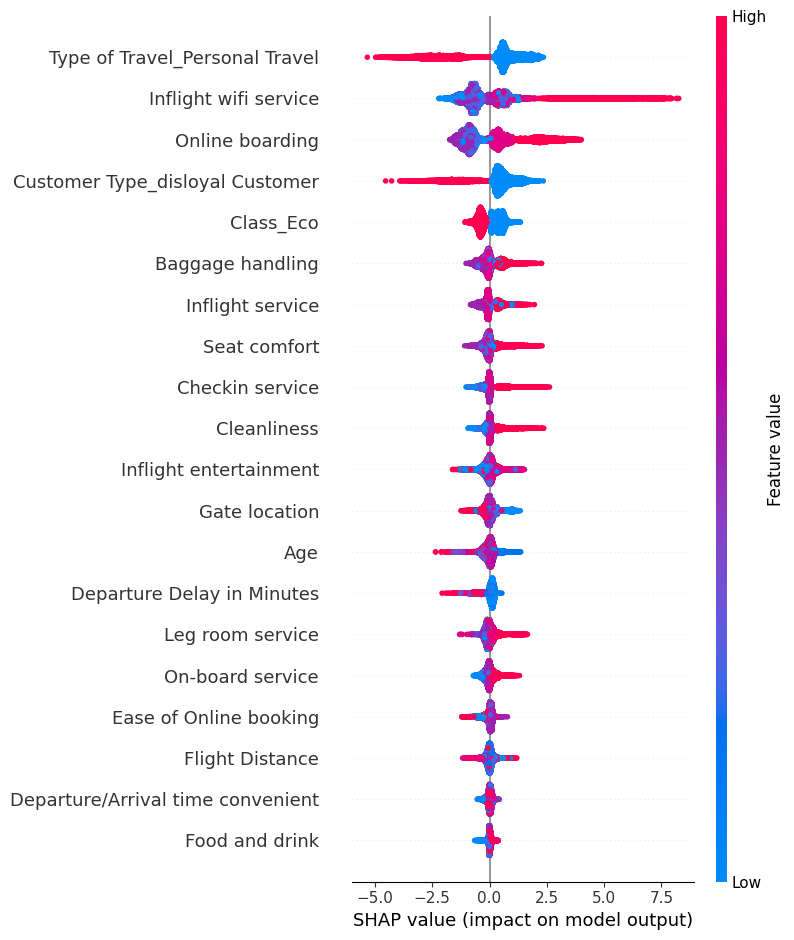

In [34]:
import shap
explainer = shap.TreeExplainer(best_xgb)  # или best_rf
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

Улучшить качество Wi-Fi, процесса онлайн посадки и работать с лояльностью. Так как данные фичи сильно влияют на удовлетворенность пассажира.

CatBoost

In [35]:
%%time
from catboost import CatBoostClassifier

X = data_new.drop('satisfaction', axis=1)
y = data_new['satisfaction']
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train_cat.shape, X_test_cat.shape)

cat_features = ['Gender', 'Customer Type', 'Class', 'Type of Travel']

cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=100
)

cat.fit(X_train_cat, y_train_cat, cat_features=cat_features)

y_test_pred_cat = cat.predict(X_test_cat)
y_train_pred_cat = cat.predict(X_train_cat)

(82875, 21) (20719, 21)
0:	learn: 0.5653422	total: 126ms	remaining: 1m 2s
100:	learn: 0.1122171	total: 8.52s	remaining: 33.7s
200:	learn: 0.0967663	total: 16.5s	remaining: 24.5s
300:	learn: 0.0882381	total: 23.9s	remaining: 15.8s
400:	learn: 0.0826773	total: 32.3s	remaining: 7.97s
499:	learn: 0.0781277	total: 39.2s	remaining: 0us
CPU times: user 1min 5s, sys: 3.69 s, total: 1min 9s
Wall time: 39.8 s


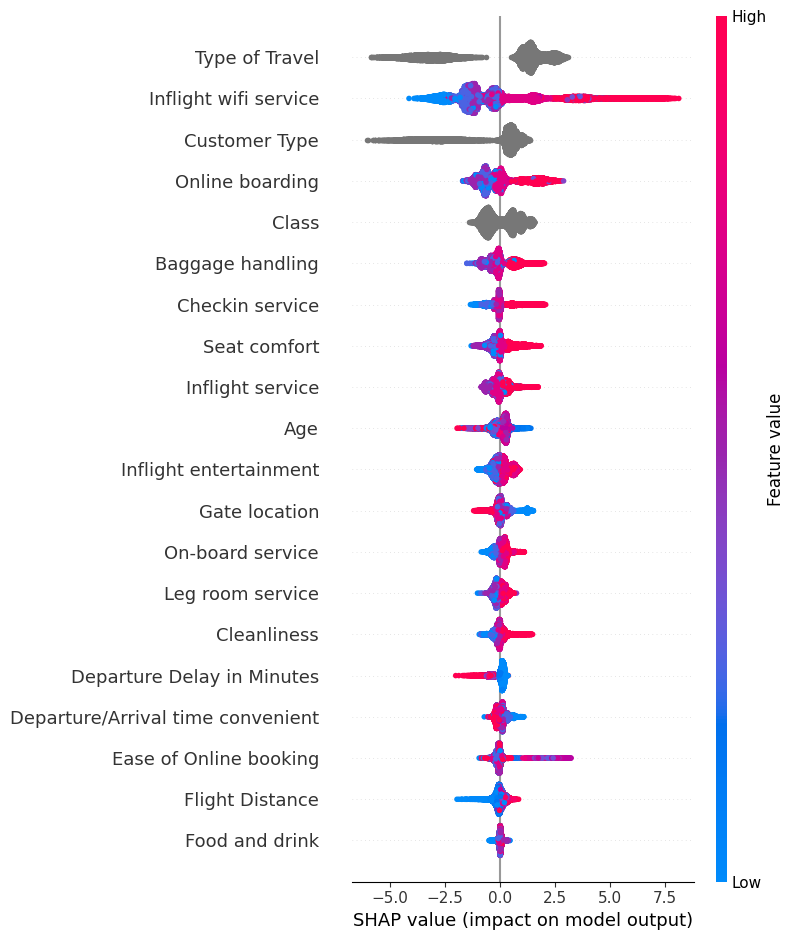

Test Accuracy: 0.9625947198223852
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     11740
           1       0.97      0.94      0.96      8979

    accuracy                           0.96     20719
   macro avg       0.96      0.96      0.96     20719
weighted avg       0.96      0.96      0.96     20719

Train Accuracy: 0.9687239819004525
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     46957
           1       0.98      0.95      0.96     35918

    accuracy                           0.97     82875
   macro avg       0.97      0.97      0.97     82875
weighted avg       0.97      0.97      0.97     82875



In [36]:
import shap
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_test_cat)

shap.summary_plot(shap_values, X_test_cat)

print("Test Accuracy:", accuracy_score(y_test_cat, y_test_pred_cat))
print(classification_report(y_test_cat, y_test_pred_cat))
print("Train Accuracy:", accuracy_score(y_train_cat, y_train_pred_cat))
print(classification_report(y_train_cat, y_train_pred_cat))

Type of Travel, Inflight wifi service, Customer Type, Online boarding и Class - важные факторы. Для категориальных переменных SHAP не всегда может чётко интерпретировать значение как «больше» или «меньше», поэтому цвет нейтрализуется.

Модель показывает высокую точность — около 95% клиентов классифицируются правильно. При этом она почти безошибочно выявляет недовольных или нейтральных клиентов: 98% из них будут пойманы и могут быть обработаны вовремя. Среди тех, кого модель считает довольными, 97% действительно довольны — то есть ложных срабатываний почти нет.

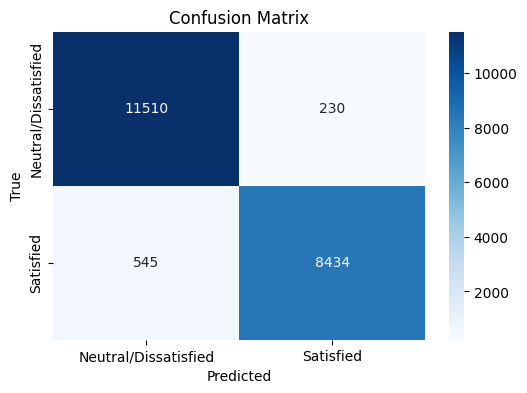

In [37]:
# Матрица
cm = confusion_matrix(y_test_cat, y_test_pred_cat)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Neutral/Dissatisfied', 'Satisfied'],
    yticklabels=['Neutral/Dissatisfied', 'Satisfied']
)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

CatBoost даёт сбалансированную модель с сильным recall для недовольных клиентов и высокой точностью по всем классам

MLPClassifier

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Лучшие параметры: {'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Лучший score (CV): 0.9416108597285068


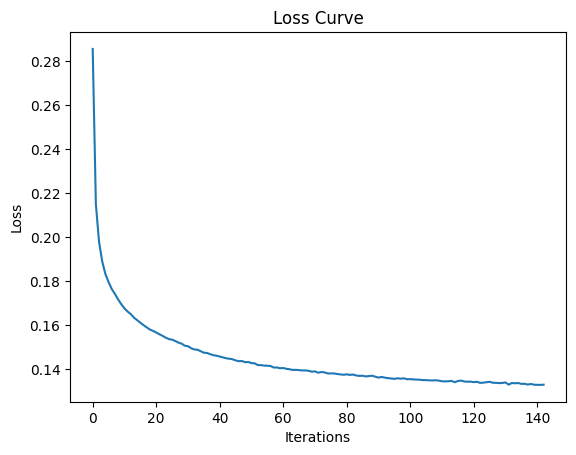

CPU times: user 1min 1s, sys: 2.43 s, total: 1min 4s
Wall time: 33min 44s


In [38]:
%%time
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

X = data.drop('satisfaction_satisfied', axis=1)
y = data['satisfaction_satisfied']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPClassifier(
    max_iter=500,
    activation='relu',
    solver='adam',
    random_state=42
)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01]
}

grid = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший score (CV):", grid.best_score_)

best_mlp = grid.best_estimator_

plt.plot(best_mlp.loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

Нет резких скачков Loss вверх — значит, что данные не «сложные» для сети и она не колеблется между недо- и переобучением.Нет роста Loss на поздних итерациях → признак отсутствия переобучения.Если бы Loss начал расти после минимума, это бы значило, что сеть «запомнила» шум, но этого не произошло.

In [39]:
# Предсказания
y_pred = best_mlp.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

train_pred = best_mlp.predict(X_train_scaled)
test_pred = best_mlp.predict(X_test_scaled)

print("Train accuracy:", accuracy_score(y_train, train_pred))
print("Test accuracy:", accuracy_score(y_test, test_pred))

Test Accuracy: 0.9416960278005695
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     11740
           1       0.96      0.90      0.93      8979

    accuracy                           0.94     20719
   macro avg       0.94      0.94      0.94     20719
weighted avg       0.94      0.94      0.94     20719

Train accuracy: 0.9527843137254902
Test accuracy: 0.9416960278005695


Нейронная сеть предсказала хуже чем CatBoost и XGBoost и в разы дольше обучалась

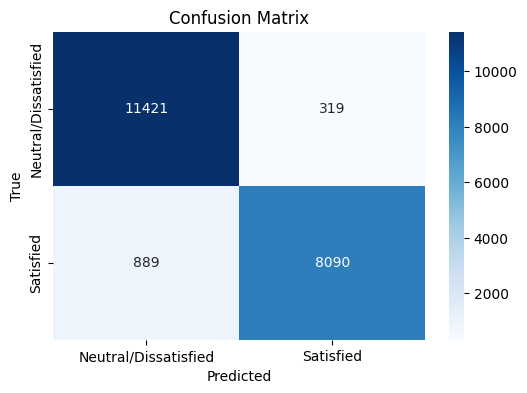

In [40]:
# Матрица
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Neutral/Dissatisfied', 'Satisfied'],
    yticklabels=['Neutral/Dissatisfied', 'Satisfied']
)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Логистическая регрессия — простая линейная модель, дала базовую точность ~88%. Хороша для понимания ключевых факторов, но ограничена в улавливании сложных взаимосвязей.

Random Forest — деревья приняли больше признаков во внимание, дали точность ~95%, метрики сбалансированы, модель устойчива.

CatBoost и XGBoost — бустинг дал ещё выше качество, AUC ≈ 0.99, precision и recall выше 95%. CatBoost оказался особенно стабилен при работе с категориальными признаками и почти не требует сложной предобработки.

MLPClassifier (нейронная сеть) — дал сопоставимо высокие метрики (~94% точность), но потребовал больше времени на обучение. Loss Curve показывает хорошее обучение без переобучения. SHAP-графики показывают интерпретируемые важные признаки.

Recall для недовольных клиентов высокий — значит, можно будет вовремя выявлять людей с негативным опытом и оперативно реагировать. Также с помощью метрик, которые оказались ключевыми можно таргетно уменьшать кол-во не довольных пассажиров (Wi-Fi, онлайн-бординг, тип поездки). В нашем случае нужно выбрать модель CatBoost, так как она показала себя на высоком уровне, ее можно легко масштабировать и при этом легко интерпретировать.